**Проект. Ford vs Ferrari: определяем модель авто по фото**

В проекте использовались методы:

transfer learning и fine-tuning
настройка LR
подобраны переменные (размер картинки, батч и т.д.)
SOTA архитектура сетей - EfficientNetB7 (самая небольшая из актуальных)
добавлена Batch Normalization и изменена архитектура “головы”
применены дополнительные функции callback Keras https://keras.io/callbacks/
TTA (Test Time Augmentation)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dl-car-classification/train.zip
/kaggle/input/sf-dl-car-classification/sample-submission.csv
/kaggle/input/sf-dl-car-classification/test.zip
/kaggle/input/sf-dl-car-classification/train.csv


In [69]:
# Обновление tensorflow
!pip install tensorflow --upgrade

In [2]:
!pip install -q efficientnet
# Загружаем обвязку под keras для использования продвинутых библиотек аугментации, например, albuminations
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-6hgetiy9
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-6hgetiy9
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=9a0dbcb0cc2e6c23e34ae6b9899ed2f8a933c1ba4a2975ec1c27a5c391176065
  Stored in directory: /tmp/pip-ephem-wheel-cache-y8xz6ibg/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

import efficientnet.tfkeras as efn

from sklearn.model_selection import train_test_split, StratifiedKFold

from ImageDataAugmentor.image_data_augmentor import *
import albumentations

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['sf-dl-car-classification']
Python       : 3.7.9 | packaged by conda-forge | (default, Feb 13 2021, 20:03:11) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


In [4]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 8  # эпох на обучение
BATCH_SIZE           = 64 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/kaggle/input/sf-dl-car-classification/'
PATH = "/kaggle/output/working/car/" # рабочая директория

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

In [5]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [7]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Распределение классов достаточно равномерное — это хорошо.

In [8]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DATA_PATH+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['test_upload', 'train']


Пример картинок (random sample)


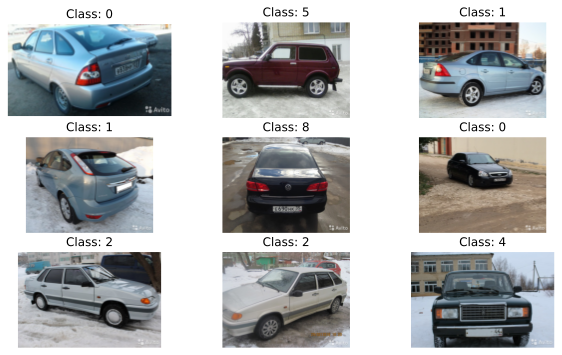

In [9]:
#Смотрим примеры картинок
print('Пример картинок (random sample)')
plt.figure(figsize=(10,6))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH + f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

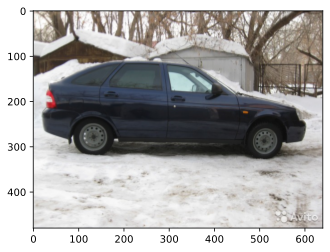

(640, 480)

In [10]:
#смотрим размер картинки
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

Аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай.

In [11]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=224, width=200),
        albumentations.CenterCrop(height=200, width=224),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )
        
test_datagen = ImageDataAugmentor(rescale=1./255)

**Генерация данных**

In [12]:
# Завернем наши данные в генератор:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


**Строим модель**

Загружаем предобученную сеть EfficientNetB7:

In [13]:
base_model = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)

258441216/258434480 [==============================] - 2s 0us/step


In [14]:
print(len(base_model.layers))

806


In [15]:
#обучаем только верхние слои "голову"
base_model.trainable = False

In [16]:
# меняем "голову"
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),) # объединяем все признаки в единый вектор 
model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization()) #добавляем BatchNormalization
model.add(L.Dropout(0.25))
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [17]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 7, 7, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               655616    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 64,756,890
Trainable params: 658,698
Non-trainable params: 64,098,192
______________________________________

In [19]:
# количество слоев 
print(len(model.layers))

6


In [20]:
len(model.trainable_variables)

6

In [21]:
# смотрим какие слои обучаются
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f3ea9071e90> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f3ea8bce5d0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f3ea8bccd50> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f3ebb7cc090> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f3e90171ed0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f3e90175550> True


**Обучаем модель**

Добавим ModelCheckpoint. Эта функция позволяет сохранять прогресс обучения модели, чтобы в нужный момент можно было его подгрузить и дообучить модель.

In [22]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

Обучаем:

In [23]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
207/207 [==============================] - 236s 1s/step - loss: 2.0741 - accuracy: 0.3251 - val_loss: 1.1930 - val_accuracy: 0.5874

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
207/207 [==============================] - 208s 1s/step - loss: 1.4701 - accuracy: 0.4881 - val_loss: 1.0323 - val_accuracy: 0.6376

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
207/207 [==============================] - 209s 1s/step - loss: 1.3412 - accuracy: 0.5293 - val_loss: 0.9946 - val_accuracy: 0.6441

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
207/207 [==============================] - 207s 999ms/step - loss: 1.3123 - accuracy: 0.5438 - val_loss: 0.9696 - val_accuracy: 0.6492

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
207/207 [==============================] - 204s 986ms/step - loss: 1.2596 - accuracy: 0.5566 - val_loss: 0.9672 - val_accuracy: 0.6526

Epoch 00005: saving model to best_model.hdf5
Epoch 6/8
207/207 [==============================] - 1

Сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model):

In [24]:
model.save('../working/model_step1.hdf5')
model.load_weights('best_model.hdf5')

In [25]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


37/37 [==============================] - 32s 851ms/step - loss: 0.8466 - accuracy: 0.6947
Accuracy: 69.47%


В итоге точность нашей модели составила 69,47 %. 

Посмотрим на графики обучения:

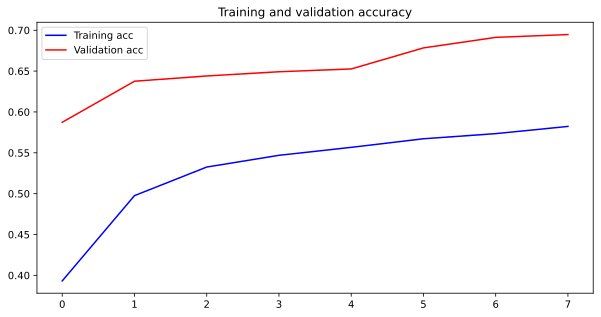

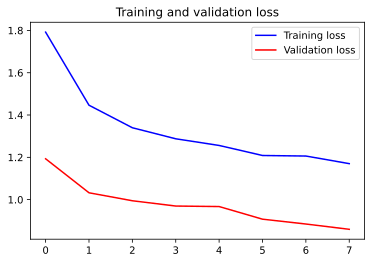

In [26]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    #plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

**FineTuning**

In [27]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  806


In [29]:
# возьмем половину слоев у базовой модели
base_model.trainable = True

# Точная настройка, начиная с этого слоя
fine_tune_at = len(base_model.layers)//2

# Заморозим все слои перед тонкой надстройкой
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [30]:
len(base_model.trainable_variables)

354

In [31]:
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f3ea9071e90> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f3ea8bce5d0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f3ea8bccd50> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f3ebb7cc090> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f3e90171ed0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f3e90175550> True


In [32]:
# уменьшим LR
LR=0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 7, 7, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               655616    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 64,756,890
Trainable params: 59,741,730
Non-trainable params: 5,015,160
____________________________________

In [34]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
207/207 [==============================] - 271s 1s/step - loss: 1.5172 - accuracy: 0.4897 - val_loss: 0.5230 - val_accuracy: 0.8201

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
207/207 [==============================] - 237s 1s/step - loss: 0.6537 - accuracy: 0.7647 - val_loss: 0.3379 - val_accuracy: 0.8832

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
207/207 [==============================] - 242s 1s/step - loss: 0.4262 - accuracy: 0.8480 - val_loss: 0.2834 - val_accuracy: 0.9017

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
207/207 [==============================] - 237s 1s/step - loss: 0.3116 - accuracy: 0.8845 - val_loss: 0.2342 - val_accuracy: 0.9171

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
207/207 [==============================] - 233s 1s/step - loss: 0.2635 - accuracy: 0.9076 - val_loss: 0.2206 - val_accuracy: 0.9184

Epoch 00005: saving model to best_model.hdf5
Epoch 6/8
207/207 [==============================] - 228s 1s

In [35]:
model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

In [36]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

37/37 [==============================] - 30s 804ms/step - loss: 0.1981 - accuracy: 0.9356
Accuracy: 93.56%


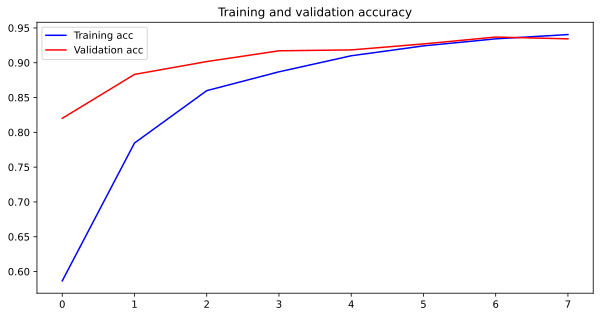

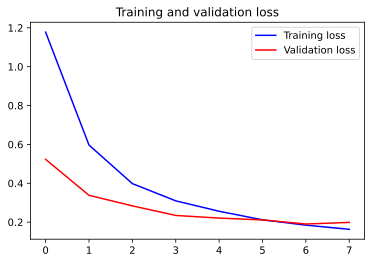

In [37]:
plot_history(history)

**Теперь используем все слои**

In [71]:
base_model.trainable = True

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

len(base_model.trainable_variables)

621

In [76]:
EPOCHS               = 8  # делаю меньше эпох на обучение, т.к. процесс будет затяжной
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 0.00001

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [77]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [80]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [81]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
        )

Epoch 1/8
1654/1654 [==============================] - 466s 282ms/step - loss: 0.3355 - accuracy: 0.8893 - val_loss: 0.1898 - val_accuracy: 0.9395

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
1654/1654 [==============================] - 461s 278ms/step - loss: 0.3130 - accuracy: 0.8956 - val_loss: 0.1987 - val_accuracy: 0.9399

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
1654/1654 [==============================] - 459s 278ms/step - loss: 0.2739 - accuracy: 0.9052 - val_loss: 0.1814 - val_accuracy: 0.9429

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
1654/1654 [==============================] - 458s 277ms/step - loss: 0.2616 - accuracy: 0.9105 - val_loss: 0.1767 - val_accuracy: 0.9438

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
1654/1654 [==============================] - 460s 278ms/step - loss: 0.2469 - accuracy: 0.9132 - val_loss: 0.1722 - val_accuracy: 0.9433

Epoch 00005: saving model to best_model.hdf5
Epoch 6/8
1654/1654 [==============

In [82]:
model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [83]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 32s 109ms/step - loss: 0.1572 - accuracy: 0.9476
Accuracy: 94.76%


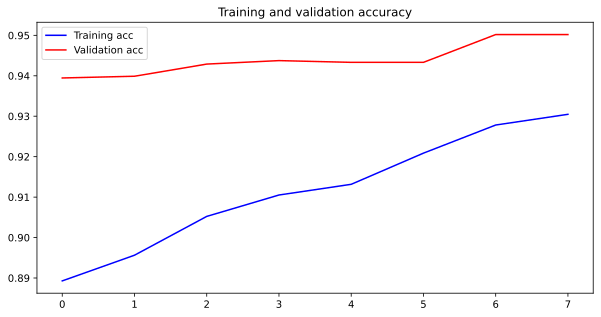

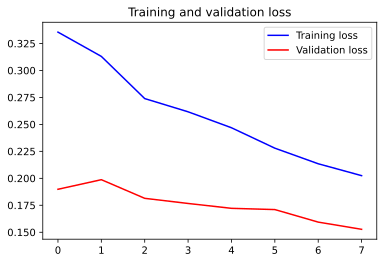

In [84]:
plot_history(history)

**Увеличим размер изображения**

In [100]:
EPOCHS               = 5
BATCH_SIZE           = 4
LR                   = 1e-5

IMG_SIZE             = 512
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [101]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )
        
test_datagen = ImageDataAugmentor(rescale=1./255)

In [102]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [103]:
base_model = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)

In [104]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [105]:
# Подгружаем ранее обученные веса
model.load_weights('best_model.hdf5')
callbacks_list = [checkpoint, earlystop]

In [106]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/5
3308/3308 [==============================] - 2005s 598ms/step - loss: 0.6654 - accuracy: 0.7908 - val_loss: 0.1223 - val_accuracy: 0.9644

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
3308/3308 [==============================] - 1972s 596ms/step - loss: 0.3671 - accuracy: 0.8867 - val_loss: 0.1069 - val_accuracy: 0.9691

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
3308/3308 [==============================] - 1974s 597ms/step - loss: 0.3009 - accuracy: 0.9052 - val_loss: 0.1008 - val_accuracy: 0.9695

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
3308/3308 [==============================] - 1974s 597ms/step - loss: 0.2449 - accuracy: 0.9240 - val_loss: 0.1064 - val_accuracy: 0.9699

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
3308/3308 [==============================] - 1974s 597ms/step - loss: 0.2246 - accuracy: 0.9338 - val_loss: 0.1020 - val_accuracy: 0.9708

Epoch 00005: saving model to best_model.hdf5


In [107]:
model.save('../working/model_step4.hdf5')
model.load_weights('best_model.hdf5')

In [108]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

583/583 [==============================] - 91s 157ms/step - loss: 0.1015 - accuracy: 0.9721
Accuracy: 97.21%


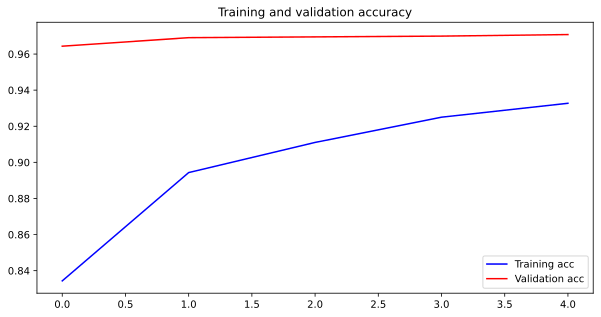

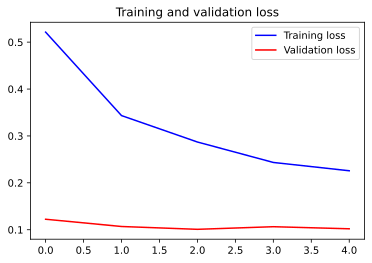

In [109]:
plot_history(history)

**Предсказываем на тестовых данных**

In [110]:
test_sub_generator.samples

6675

In [111]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1669/1669 [==============================] - 259s 153ms/step


In [112]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [113]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,9


**TTA**

In [114]:
model.load_weights('best_model.hdf5')

In [115]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=220, width=200),
        albumentations.CenterCrop(height=200, width=220),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])
      
test_datagen = ImageDataAugmentor( 
    rescale=1./255,
    augment = AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

In [116]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


In [117]:
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1669/1669 [==============================] - 265s 159ms/step


In [118]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_TTA.csv', index=False)
print('Save submit')

Save submit


In [120]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,9


In [ ]:
# Clean PATH
import shutil
shutil.rmtree(PATH)